# Variational Quantum Eigensolver

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

It is widely believed that one of the most promising applications of quantum computing in the near future is solving quantum chemistry problems [1-2]. **Variational Quantum Eigensolver** (VQE) is a strong proof to this possibility of studying quantum chemistry with **Noisy Intermediate-Scale Quantum** (NISQ) devices [1-4]. The core task is to solve the ground state of any molecular Hamiltonian $\hat{H}$ by preparing a parametrized wave function ansatz $|\Psi(\boldsymbol\theta)\rangle$ on a quantum computer and adopt classical optimization methods (e.g. gradient descent) to adjust the parameters $\boldsymbol\theta$ to minimize the expectation value $\langle \Psi(\boldsymbol\theta)|\hat{H}|\Psi(\boldsymbol\theta)\rangle$. This approach is based on the **Rayleigh-Ritz variational principle**. 

$$
E_0 = \min_{\boldsymbol\theta} \langle \Psi(\boldsymbol\theta)|\hat{H}|\Psi(\boldsymbol\theta)\rangle.
\tag{1}
$$

where $E_0$ denotes the ground state energy. Numerically, it can be understood as finding the smallest eigenvalue $\lambda_{\min}$ of a **discretized** Hamiltonian $H$ (hermitian matrix) and its corresponding eigenvector $|\Psi_0\rangle$. How such a discretization can be done on a classical computer belongs to the art of quantum chemistry and is far beyond the scope of this tutorial. We will discuss this part with a few words in the background section. In general, such a Hamiltonian $H$ is expressed as a weighted sum of Pauli spin operators $\{X,Y,Z\}$ (native to quantum devices) such that this information can be processed on a quantum computer.

$$
H = \sum_k c_k ~ \bigg( \bigotimes_{j=0}^{M-1} \sigma_j^{(k)} \bigg),
\tag{2}
$$

where $\sigma_j^{(k)} \in \{I,X,Y,Z\}$ and $M$ stands for qubit number. We refer this form of Hamiltonian as **Pauli strings**. For example, 

$$
H= 0.12~Y_0 \otimes I_1-0.04~X_0\otimes Z_1.
\tag{3}
$$

In the next section, we will provide a brief review on the electronic structure problem which essentially tells us where does the Hamiltonian $H$ come from. For those who are already familiar with this topic or only interested in how to implement VQE on Paddle Quantum, please skip this part and jump into the illustrative example of hydrogen molecule $H_2$.

## Background: the electronic structure problem

In this section, we focus on one of the fundamental problems in quantum chemistry --  **the electronic structure problem**. To be more specific, we are interested in the low lying energy eigenstates of any given molecule. These knowledge could help predict reaction rates and location of stable structures [5]. Suppose a molecule consists of $N_n$ nuclei and $N_e$ electrons, the first quantized (canonical quantization) Hamiltonian operator $\hat{H}_{mol}$ describing the total energy of this molecular system can be written as

$$
\begin{align}
\hat{H}_{\text{mol}} & = -\sum_{i}\frac{\nabla_{R_i}^2}{2M_i} - \sum_{i} \frac{\nabla_{r_i}^2}{2} -\sum_{i,j}\frac{Z_i}{\lvert R_i - r_j\lvert} + \sum_{i,j>i}\frac{Z_iZ_j}{\lvert R_i - R_j\lvert} + \sum_{i, j>i}\frac{1}{\lvert r_i - r_j\lvert}, 
\tag{4}
\end{align}
$$

where $R_i, M_i,$ and $Z_i$ denote the position, mass and atomic number (the number of protons) of the $i^{th}$ nucleus, and the positions of electrons are $r_i$. The first two sums describe the kinetic energy of nuclei and electrons, respectively. The third sum describes the attractive Coulomb interaction between the positively charged nuclei and the negatively charged electrons. The last two terms represent the repulsive nuclei-nuclei and electron-electron interactions.  Here, the molecular Hamiltonian $\hat{H}_\text{mol}$ is already in atomic units of energy, **Hartree**. 1 Hartree is $[\hbar^2/(m_ee^2a_0^2)] = 27.2$ eV or 630 kcal/mol, where $m_e, e,$ and $a_0$ stand for the mass of electron, charge of electron, and Bohr radius. 


**Note:** The spin-orbit interaction and hyperfine interaction are not considered in this picture. They can be treated as perturbations if necessary. 

### Born-Oppenheimer approximation

Since the nuclei are much heavier than electrons, the electrons will move much faster than the nuclei. It is reasonable to treat the positions of nuclei as fixed, $R_i =$ constants. This is known as the Born-Oppenheimer approximation by decoupling the behavior of nuclei and electrons in time scale. Consequently, the kinetic energy term of nuclei will disappear and the nuclei-nuclei repulsive interaction term can be viewed as an energy shift (independent of electron positions $r_i$). We could derive the electronic Hamiltonian $\hat{H}_{\text{electron}}$ as

$$
\begin{align}
\hat{H}_{\text{electron}} & =  - \sum_{i} \frac{\nabla_{r_i}^2}{2} -\sum_{i,j}\frac{Z_i}{\lvert R_i - r_j\lvert} + \sum_{i, j>i}\frac{1}{\lvert r_i - r_j\lvert} 
\tag{5},
\end{align}
$$

The energy levels of the electrons in the molecule can be found by solving the time independent Schrödinger equation

$$
\hat{H}_{\text{electron}} |\Psi_n \rangle = E_n |\Psi_n \rangle,
\tag{6}
$$

where $n$ stands for the energy level. Notice the electron repulsion terms scale as $N_e(N_e-1)/2$ which means for the Oxygen molecule $O_2$ carrying 16 electrons there will be 120 electron repulsion terms in total! In general, this problem cannot be solved analytically. As Dirac concluded in [Quantum mechanics of many-electron systems](https://royalsocietypublishing.org/doi/10.1098/rspa.1929.0094) [6],

> *The underlying physical laws necessary for the mathematical theory of a large part of physics and the whole of chemistry are thus completely known, and the difficulty is only that the exact application of these laws leads to equations much too complicated to be soluble.*                                                                                                                                                                  
>
> ​																			-- Paul Dirac (1929)

A straightforward numerical approach is discretizing the infinite-dimensional Hilbert space into equidistant grid points where linear algebra guides the whole calculation. Suppose each axis of space is discretized into $k$ points, the $N$-electron (drop the subscript e for simplicity) wave function can be written as [2]

$$
|\Psi \rangle = \sum_{\mathbf{x_1}, \ldots, \mathbf{x_N}} \psi(\mathbf{x_1}, \ldots, \mathbf{x_N}) \mathcal{A}(|\mathbf{x_1}, \ldots, \mathbf{x_N}\rangle).
\tag{7}
$$

where coordinate $|\mathbf{x_j}\rangle = |r_j\rangle |\sigma_j\rangle$ records the spatial location and spin of the $j^{th}$ electron, $|r_j\rangle  = |x_j,y_j,z_j\rangle$ for $j\in \{1,2,\cdots,N\}$, $x_j,y_j,z_j \in \{0,1,\cdots,k-1\}$ and  $\sigma_j \in \{\downarrow,\uparrow\}$ for spin down or up.  There will be $k^{3N}\times 2^{N}$ complex amplitudes in total. Here, $\mathcal{A}$ denotes anti-symmetrization and a consequence of the Pauli exclusion principle (electrons are fermion), and $\psi(\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_N})=\langle\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_N}|\Psi\rangle$. One can see that storing such a wave function already requires **exponentially growing memory** with respect to the number of electrons $N$. This would make classical simulation methods based on this naive numerical approach intractable for systems size larger than few tens of electrons. Now, the question becomes can we prepare such a wave function $|\Psi\rangle$ directly on a quantum computer and measure the expectation value $E_0$? In the next section, let's take the simplest molecular system -- hydrogen molecule $H_2$ as a concrete example.



**Note:** A detailed review on quantum chemistry and existing classical computational methods are far beyond the scope of this tutorial, we refer the enthusiastic readers to the standard textbooks *'Molecular Electronic-Structure Theory'* [5] by Helgaker and *'Modern Quantum Chemistry: Introduction to Advanced Electronic Structure Theory'* [7] by Szabo & Ostlund. To bridge to knowledge gap between quantum chemistry and quantum computing, please check the following review papers [Quantum computational chemistry](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015003) [2] and [Quantum Chemistry in the Age of Quantum Computing](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803) [1].

**Note:** For energy calculation, it is desired to reach the **chemical accuracy** of $1.6\times10^{-3}$ Hartree or 1 kcal/mol . 

## Ground state of the hydrogen molecule $H_2$

### Building electronic Hamiltonian

First of all, let us import the necessary libraries and packages.



In [1]:
import os
import platform
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy
from numpy import concatenate
from numpy import pi as PI
from numpy import savez, zeros

import paddle
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix
from paddle_quantum.VQE.chemistrysub import H2_generator

To analyze specific molecules, we need several key information such as **geometry**, **basis set** (such as STO-3G), **multiplicity**, and **charge** to obtain the discretized Hamiltonian $H$. Specifically, through our built-in quantum chemistry toolkit, fermion-to-qubit mapping technology can be used to output the qubit Hamiltonian of hydrogen molecule $H_2$,

In [2]:
Hamiltonian, N = H2_generator()

For more advanced users, we provide a simple tutorial on how to generate such a Hamiltonian. Install the following two packages first (**only available for Mac/Linux users, not available to Windows users temporarily**):

In [3]:
!pip install openfermion
clear_output()

In [4]:
!pip install openfermionpyscf
clear_output()

In [3]:
# Operating system information
sysStr = platform.system()

# Decide which operating system the user is using
if sysStr in ('Linux', 'Darwin'):

    import openfermion 
    import openfermionpyscf 

    # Please check whether the geometric configuration file of h2 is downloaded correctly
    geometry = 'h2.xyz'
    # geometry = [('H', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 0.74))]
    basis = 'sto-3g'
    charge = 0
    multiplicity = 1

    # Generate Hamiltonian
    molecular_hamiltonian = openfermionpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
    qubit_op = openfermion.transforms.jordan_wigner(molecular_hamiltonian)
    
    # Print result
    print("The generated h2 Hamiltonian is \n", qubit_op)

The generated h2 Hamiltonian is 
 -0.042078976477822494 [] +
-0.04475014401535163 [X0 X1 Y2 Y3] +
0.04475014401535163 [X0 Y1 Y2 X3] +
0.04475014401535163 [Y0 X1 X2 Y3] +
-0.04475014401535163 [Y0 Y1 X2 X3] +
0.17771287465139946 [Z0] +
0.17059738328801055 [Z0 Z1] +
0.12293305056183797 [Z0 Z2] +
0.1676831945771896 [Z0 Z3] +
0.17771287465139946 [Z1] +
0.1676831945771896 [Z1 Z2] +
0.12293305056183797 [Z1 Z3] +
-0.24274280513140462 [Z2] +
0.1762764080431959 [Z2 Z3] +
-0.24274280513140462 [Z3]


**Note:** This Hamiltonian is generated with an interatomic distance of $d = 74$ pm. 

In addition to hydrogen molecule $H_2$, we also provide the geometric configuration file of hydrogen fluoride (HF) molecule `hf.xyz`. If you need to test the geometric configuration of more molecules, please check out this [database](http://smart.sns.it/molecules/index.html). In addition, we also need to convert the Hamiltonian into the Pauli string format supported by Paddle Quantum. Here we provide this interface.



In [4]:
def Hamiltonian_str_convert(qubit_op):
    '''
    Convert the Hamiltonian information provided above into Pauli strings supported by Paddle Quantum

    H = [[1.0, "z0,x1"], [-1.0, "y0,z1"], ...]
    '''
    info_dic = qubit_op.terms
    
    def process_tuple(tup):
        if len(tup) == 0:
            return 'i0'
        else:
            res = ''
            for ele in tup:
                res += ele[1].lower()
                res += str(ele[0])
                res += ','
            return res[:-1]
    H_info = []
    
    for key, value in qubit_op.terms.items():
        H_info.append([value.real, process_tuple(key)])
    
    return H_info

if sysStr in ('Linux', 'Darwin'):
    Hamiltonian = Hamiltonian_str_convert(qubit_op)

### Building QNN and trial wave function

To implement VQE, we firstly need to design a quantum neural network QNN to prepare the wave function ansatz $|\Psi(\boldsymbol\theta)\rangle$. Here, we provide a 4-qubit quantum circuit template with a depth of $D$ blocks. The dotted frame in the figure below denotes a single block:


![Utheta.jpg](https://release-data.cdn.bcebos.com/PIC%2FUtheta.jpg)

Next, we use the `UAnsatz` class and the built-in `real_entangled_layer(theta, D)` circuit template in Paddle Quantum to realize this QNN.



In [5]:
def U_theta(theta, Hamiltonian, N, D):
    """
    Quantum Neural Network
    """
    
    # Initialize the quantum neural network according to the number of qubits N
    cir = UAnsatz(N)
    
    # Built-in {R_y + CNOT} circuit template
    cir.real_entangled_layer(theta[:D], D)
    
    # Lay R_y gates in the last row
    for i in range(N):
        cir.ry(theta=theta[D][i][0], which_qubit=i)
        
    # The quantum neural network acts on the default initial state |0000>
    cir.run_state_vector()
    
    # Calculate the expected value of a given Hamiltonian
    expectation_val = cir.expecval(Hamiltonian)

    return expectation_val, cir

### Setting up the loss function and model

Now that we have the target Hamiltonian and QNN, we will further define the training model and loss function. By applying the QNN $U(\theta)$ on the initial state $|0..0\rangle$, we get the output state $|\psi(\boldsymbol\theta)\rangle $. Then, the loss function to be minimized is the expectation value, 


$$
\min_{\boldsymbol\theta}  \mathcal{L}(\boldsymbol \theta) = \min_{\boldsymbol\theta} \langle \Psi(\boldsymbol\theta)|H |\Psi(\boldsymbol\theta)\rangle
= \min_{\boldsymbol\theta} \sum_k c_k~\langle \Psi(\boldsymbol\theta)| \bigotimes_j \sigma_j^{(k)}|\Psi(\boldsymbol\theta)\rangle.
\tag{8}
$$

In [6]:
class StateNet(paddle.nn.Layer):

    def __init__(self, shape, dtype="float64"):
        super(StateNet, self).__init__()
        
        # Initialize the theta parameter list and fill the initial value with a uniform distribution of [0, 2*pi]
        self.theta = self.create_parameter(shape=shape, 
                                           default_initializer=paddle.nn.initializer.Uniform(low=0.0, high=2*PI),
                                           dtype=dtype, is_bias=False)
        
    # Define loss function and forward propagation mechanism
    def forward(self, N, D):
        
        # Calculate the loss function/expected value
        loss, cir = U_theta(self.theta, Hamiltonian, N, D)

        return loss, cir

### Hyper-parameters

Before training the QNN, we also need to set some training hyper-parameters, mainly the learning rate (LR), the number of iterations (ITR), and the depth (D) of repeated blocks. 

In [7]:
ITR = 80  # Set the number of optimization iterations
LR = 0.4   # Set the learning rate
D = 2      # Set the depth of the repetitive calculation module in QNN

### Training

After all the training model parameters are set, we convert the data into Tensor in the Paddle, and then train the quantum neural network. The results of the training process is stored in the summary_data file.


In [10]:
# Determine the parameter dimension of the network
net = StateNet(shape=[D + 1, N, 1])


# Generally speaking, we use Adam optimizer to obtain relatively good convergence,
# You can change it to SGD or RMS prop.
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

# Record optimization results
summary_iter, summary_loss = [], []

# Optimization loop
for itr in range(1, ITR + 1):

    # Forward propagation to calculate loss function
    loss, cir = net(N, D)

    # Use back propagation to minimize the loss function
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # Record optimization results
    summary_loss.append(loss.numpy())
    summary_iter.append(itr)

    # Print result
    if itr % 20 == 0:
        print("iter:", itr, "loss:", "%.4f" % loss.numpy())
        print("iter:", itr, "Ground state energy:", "%.4f Ha" 
                                            % loss.numpy())
    if itr == ITR:
        print("\nThe trained circuit:")
        print(cir)

# Save the training results to the output folder
os.makedirs("output", exist_ok=True)
savez("./output/summary_data", iter = summary_iter, 
                               energy=summary_loss)

iter: 20 loss: -1.0687
iter: 20 Ground state energy: -1.0687 Ha
iter: 40 loss: -1.1313
iter: 40 Ground state energy: -1.1313 Ha
iter: 60 loss: -1.1355
iter: 60 Ground state energy: -1.1355 Ha
iter: 80 loss: -1.1360
iter: 80 Ground state energy: -1.1360 Ha

The trained circuit:
--Ry(1.557)----*--------------X----Ry(1.578)----*--------------X----Ry(3.142)--
               |              |                 |              |               
--Ry(1.571)----X----*---------|----Ry(4.916)----X----*---------|----Ry(1.390)--
                    |         |                      |         |               
--Ry(2.972)---------X----*----|----Ry(7.847)---------X----*----|----Ry(3.104)--
                         |    |                           |    |               
--Ry(4.663)--------------X----*----Ry(1.577)--------------X----*----Ry(3.147)--
                                                                               


### Benchmarking
We have now completed the training of the quantum neural network, and the estimated value of the ground state energy obtained is $E_0 \approx -1.1361$ Hartree, we compare it with the theoretical value $E_0 = -1.13618$ to benchmark our model. The estimation obtained with VQE agree with a full configuration-interaction (FCI) calculation within chemical accuracy $\varepsilon = 1.6 \times 10^{-3}$ Hartree.



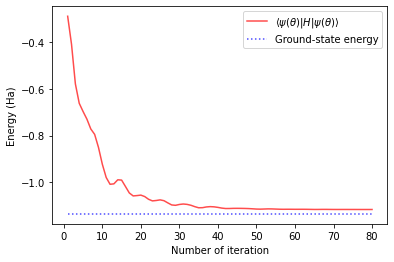

In [9]:
result = numpy.load('./output/summary_data.npz')

eig_val, eig_state = numpy.linalg.eig(
                     pauli_str_to_matrix(Hamiltonian, N))
min_eig_H = numpy.min(eig_val.real)
min_loss = numpy.ones([len(result['iter'])]) * min_eig_H

plt.figure(1)
func1, = plt.plot(result['iter'], result['energy'], 
                  alpha=0.7, marker='', linestyle="-", color='r')
func_min, = plt.plot(result['iter'], min_loss, 
                  alpha=0.7, marker='', linestyle=":", color='b')
plt.xlabel('Number of iteration')
plt.ylabel('Energy (Ha)')

plt.legend(handles=[
    func1,
    func_min
],
    labels=[
        r'$\left\langle {\psi \left( {\theta } \right)} '
        r'\right|H\left| {\psi \left( {\theta } \right)} \right\rangle $',
        'Ground-state energy',
    ], loc='best')

#plt.savefig("vqe.png", bbox_inches='tight', dpi=300)
plt.show()

## Determining the interatomic distance

Recall the above calculation is done with an interatomic distance $d = 74$ pm between two hydrogen atoms. Another interesting aspect we can try with VQE is determining the true interatomic distance by modifying the `h2.xyz` file. The results are summarize in figure below,

![vqe-fig-dist](figures/vqe-fig-distance.png)

The lowest value is found around $d = 74$ pm (1 pm = $1\times 10^{-12}$m), which is consistent with the [experimental data](https://cccbdb.nist.gov/exp2x.asp?casno=1333740&charge=0) $d_{exp} (H_2) = 74.14$ pm.

_______

## References

[1] Cao, Yudong, et al. Quantum Chemistry in the Age of Quantum Computing. [Chemical reviews 119.19 (2019): 10856-10915.](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803)

[2] McArdle, Sam, et al. Quantum computational chemistry. [Reviews of Modern Physics 92.1 (2020): 015003.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015003)


[3] Peruzzo, A. et al. A variational eigenvalue solver on a photonic quantum processor. [Nat. Commun. 5, 4213 (2014).](https://www.nature.com/articles/ncomms5213)

[4] Moll, Nikolaj, et al. Quantum optimization using variational algorithms on near-term quantum devices. [Quantum Science and Technology 3.3 (2018): 030503.](https://iopscience.iop.org/article/10.1088/2058-9565/aab822)

[5] Helgaker, Trygve, Poul Jorgensen, and Jeppe Olsen. Molecular electronic-structure theory. John Wiley & Sons, 2014.

[6] Dirac, Paul Adrien Maurice. Quantum mechanics of many-electron systems. [Proceedings of the Royal Society of London. Series A, Containing Papers of a Mathematical and Physical Character 123.792 (1929): 714-733.](https://royalsocietypublishing.org/doi/10.1098/rspa.1929.0094)

[7] Szabo, Attila, and Neil S. Ostlund. Modern quantum chemistry: introduction to advanced electronic structure theory. Courier Corporation, 2012.